In [2]:
# importing libraries to clean up data
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re 


In [3]:
# reading in our first dataset
df = pd.read_csv('Movie_dataset_cleaned.csv')

In [4]:
# dropping unnecessary column
df.drop(columns='Unnamed: 0', inplace=True)

In [5]:
# noticing quite a big class imbalance, this prompted the decision to collect more data
df['positive'].value_counts()

positive
1    8019
0    2872
Name: count, dtype: int64

In [6]:
# reading in our second dataset to help balance the classes
df2 = pd.read_csv('Movie_Dataset.csv')

In [7]:
# creating numerical variables for the target variable, our first dataset this was already done prior
df2['rating'] = df2['rating'].map({'fresh': '1', 'rotten': '0'})

In [8]:
# rename rating column to positive
df2.rename(columns={'rating': 'positive'}, inplace = True)

In [9]:
# df2 contains significantly more negative examples
df2['positive'].value_counts()

positive
0    7414
1    4650
Name: count, dtype: int64

In [10]:
# calculating the class split when both datasets are added togetherr
total = (10286+12669)
percent_of_negative= round((10286/total) * 100,2)
percent_of_positive = 100 - percent_of_negative

print(f'The dataset contains {percent_of_positive}% of positive examples')
print(f'The dataset contains {percent_of_negative}% of negative examples')




The dataset contains 55.19% of positive examples
The dataset contains 44.81% of negative examples


In [11]:
# turning our datasets into one for modeling
reviews_df = pd.concat([df,df2], ignore_index=True)


In [12]:
# resetting the index
reviews_df = reviews_df.reset_index(drop=True)


In [13]:
# assigning positive column to correct datatype, int
reviews_df['positive'] = reviews_df['positive'].astype(int)


In [14]:
# total value counts of our df we will use to build models
reviews_df['positive'].value_counts()

positive
1    12669
0    10286
Name: count, dtype: int64

In [15]:
# ensuring any accidental duplicate reviews are dropped
reviews_df.drop_duplicates(subset='text', inplace=True)



In [16]:
# checking if we have any null values
reviews_df.isnull().sum()


positive    0
text        1
dtype: int64

In [17]:
# dropping null values
reviews_df.dropna(inplace=True)

In [18]:
# final value counts of our df
reviews_df['positive'].value_counts()

positive
1    10831
0     8467
Name: count, dtype: int64

In [19]:
# cleaning up our review text in case of weird characters
def clean_text(text):

    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [20]:
# applying function across every review
reviews_df['text'] = reviews_df['text'].apply(lambda x: clean_text(x))

In [21]:
# looking into how many unique words we have in our df
unique_words = set()
for text in reviews_df['text']:
  unique_words.update(word for word in text.split())

len(unique_words)

43312

In [22]:
# creating a dictionary to count the occurence of each word
word_count = {}
for text in reviews_df['text']:
    for word in text.split():
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1 


In [434]:
# sorting it by values descending
sorted_word_count = {k: v for k, v in sorted(word_count.items(), key=lambda item: item[1], reverse=True)}

sorted_word_count

{'the': 24796,
 'a': 16775,
 'and': 14242,
 'of': 13315,
 'to': 10482,
 'is': 8897,
 'in': 6111,
 'that': 5822,
 'it': 5759,
 'but': 4187,
 'with': 4090,
 'this': 3846,
 'as': 3839,
 'for': 3647,
 'its': 3034,
 'an': 2781,
 'film': 2634,
 'on': 2299,
 'be': 2198,
 "it's": 2032,
 'you': 1980,
 'not': 1975,
 'movie': 1938,
 'are': 1706,
 'more': 1686,
 'at': 1645,
 'from': 1621,
 'by': 1563,
 'like': 1529,
 'all': 1487,
 'have': 1478,
 'i': 1445,
 'one': 1428,
 'has': 1397,
 'than': 1309,
 'about': 1279,
 'if': 1224,
 'just': 1153,
 'it’s': 1145,
 'so': 1109,
 'his': 1084,
 'what': 1082,
 'or': 1034,
 'into': 1004,
 'some': 980,
 'will': 962,
 'story': 941,
 'up': 920,
 'even': 906,
 'much': 905,
 'good': 891,
 'too': 856,
 'out': 855,
 'most': 842,
 'action': 830,
 'who': 797,
 'while': 795,
 'was': 758,
 'can': 747,
 'there': 731,
 'make': 695,
 'no': 694,
 'when': 692,
 'their': 684,
 'they': 651,
 'enough': 637,
 'very': 613,
 'best': 611,
 'been': 599,
 'we': 591,
 'time': 582,
 'ne

In [23]:
# importing neccesary librairies for model building and evaluation
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score, roc_curve





In [24]:
# splitting up columns
X_text = reviews_df['text']
Y_review = reviews_df['positive']

In [25]:
# splitting up our dataset into training and testing data (90/10 partition)
X_train, X_test, Y_train, Y_test = train_test_split(X_text, Y_review, test_size=0.1, random_state=8)

We will implement different feature engineering techniques on a DT model and then try the best peforming technique on other models
1. Bag of words
2. TFIDF
3. n-grams

##### Decision Tree classification(Bag of words)

In [26]:
# defining our classifier and feature engineering with specific hyperparameters
decision_tree = DecisionTreeClassifier(random_state=8, max_depth=12)
vectorizer = CountVectorizer(binary=True)

# transforming our data in bag of words
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# fitting our dt to the training data to then make predictions
decision_tree.fit(X_train_transformed, Y_train)
training_accuracy = decision_tree.score(X_train_transformed, Y_train)
test_accuracy = decision_tree.score(X_test_transformed, Y_test)
accs = np.mean(cross_val_score(decision_tree, X_train_transformed, Y_train, scoring="accuracy", cv=5))

# printing out the accuracies of our model
print (f'Training Accuracy: {training_accuracy:.3f}')
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Cross-Validation Accuracy: {accs:.3f}")




Training Accuracy: 0.638
Test Accuracy: 0.616
Cross-Validation Accuracy: 0.604


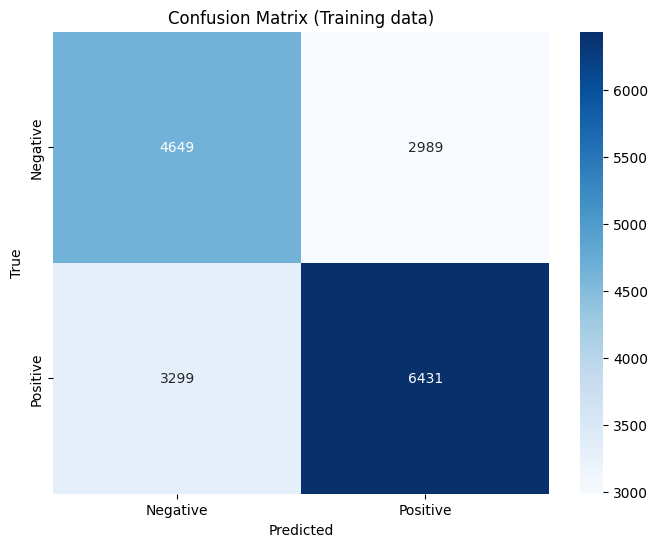

In [27]:
# confusion matrix for training data (built to compare for potential overfitting)
# will only present this for first model for simplicity
predictions = decision_tree.predict(X_train_transformed)
cm = confusion_matrix(Y_train, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Training data)')
plt.show()

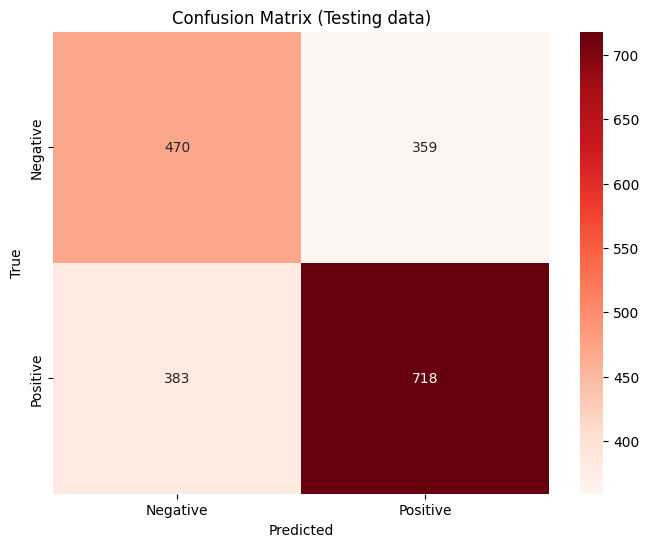

In [443]:
# confusion matrix for testing data
predictions = decision_tree.predict(X_test_transformed)
cm = confusion_matrix(Y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Testing data)')
plt.show()

##### Evaluation of confusion matrix((Testing Data)
Positive class:            
- Precision: .667
- Recall: .652
- F1 Score: .659

Negative class:
- Precision: .551
- Recall: .567
- F1 Score: .559

----



#### TFIDF

In [28]:
# defining our classifier and feature engineering with specific hyperparameters
decision_tree = DecisionTreeClassifier(random_state=8, max_depth=12)
vectorizer = TfidfVectorizer(binary=True)

# transforming our data using TFIDF engineering
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# fitting our dt to the training data to then make predictions
decision_tree.fit(X_train_transformed, Y_train)
training_accuracy = decision_tree.score(X_train_transformed, Y_train)
test_accuracy = decision_tree.score(X_test_transformed, Y_test)
accs = np.mean(cross_val_score(decision_tree, X_train_transformed, Y_train, scoring="accuracy", cv=5))

# printing out the accuracies of our model
print (f'Training Accuracy: {training_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')
print (f'Cross-Validation Accuracy: {accs:.3f}')

Training Accuracy: 0.640
Test Accuracy: 0.619
Cross-Validation Accuracy: 0.596


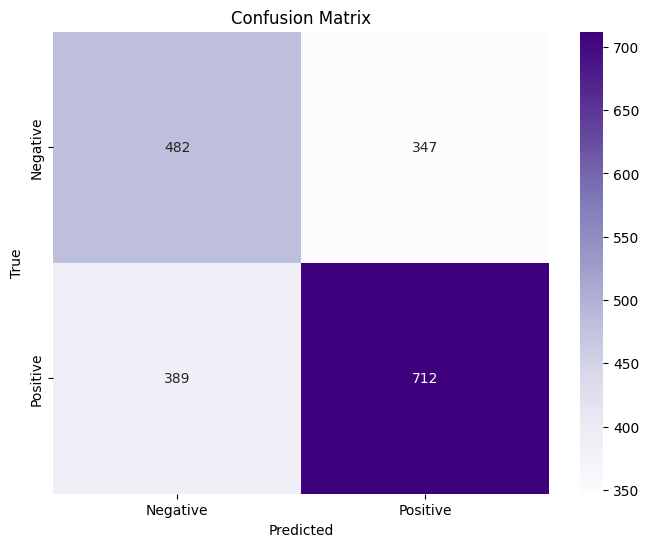

In [446]:
# confusion matrix for testing
predictions = decision_tree.predict(X_test_transformed)
cm = confusion_matrix(Y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##### Evaluation of confusion matrix
Positive class:            
- Precision: .672
- Recall: .647
- F1 Score: .659

Negative class:
- Precision: .553
- Recall: .581
- F1 Score: .567

----

#### n-grams

In [29]:
# defining our classifier and feature engineering with specific hyperparameters
decision_tree = DecisionTreeClassifier(random_state=8, max_depth=12)
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))

# transforming our data using n-grams
X_train_bigram = bigram_vectorizer.fit_transform(X_train)
X_test_bigram = bigram_vectorizer.transform(X_test)

# fitting our dt to the training data to then make predictions
decision_tree.fit(X_train_bigram, Y_train)
training_accuracy = decision_tree.score(X_train_bigram, Y_train)
test_accuracy = decision_tree.score(X_test_bigram, Y_test)
accs = np.mean(cross_val_score(decision_tree, X_train_bigram, Y_train, scoring="accuracy", cv=5))

# printing out the accuracies of our model
print (f'Training Accuracy: {training_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')
print (f'Cross-Validation Accuracy: {accs:.3f}')



Training Accuracy: 0.636
Test Accuracy: 0.613
Cross-Validation Accuracy: 0.603


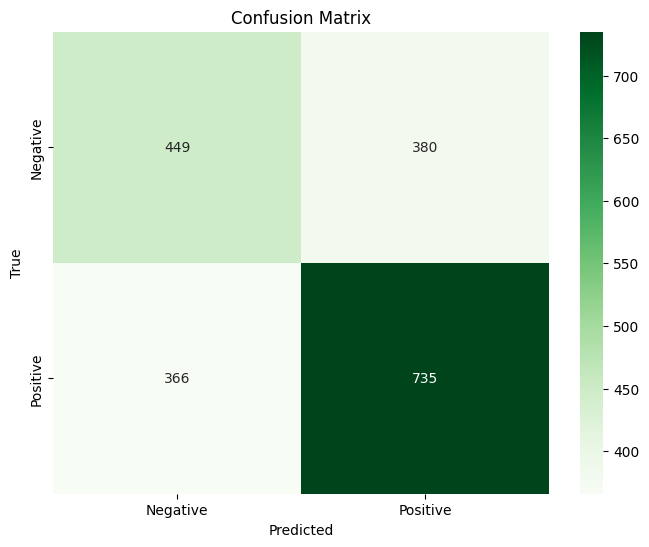

In [30]:
# confusion matrix 
predictions = decision_tree.predict(X_test_bigram)
cm = confusion_matrix(Y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##### Evaluation of confusion matrix
Positive class:            
- Precision: .659
- Recall: .668
- F1 Score: .663

Negative class:
- Precision: .551
- Recall: .542
- F1 Score: .546

----

##### Lets try out different models using TFIDF or n-gram engineering to compare peformance

#### Random Forest

In [31]:
# defining our classifier and feature engineering with specific hyperparameters
random_forest = RandomForestClassifier(random_state=8, n_estimators=80, max_depth=18)
vectorizer = TfidfVectorizer(binary=True)

# transforming our data using TFIDF
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# fitting our RF to the training data to then make predictions
random_forest.fit(X_train_transformed, Y_train)
training_accuracy = random_forest.score(X_train_transformed, Y_train)
test_accuracy = random_forest.score(X_test_transformed, Y_test)
accs = np.mean(cross_val_score(random_forest, X_train_transformed, Y_train, scoring="accuracy", cv=5))

# printing out the accuracies of our model
print (f'Training Accuracy: {training_accuracy:.3f}')
print(f"Test Accuracy: {test_accuracy:.3f}")
print (f'Cross-Validation Accuracy: {accs:.3f}')




Training Accuracy: 0.637
Test Accuracy: 0.607
Cross-Validation Accuracy: 0.600


#### Logistic Regression

In [32]:
# defining our classifier and feature engineering with specific hyperparameters
logistic_regression = LogisticRegression(random_state=8, max_iter=100, penalty='l2')
vectorizer = TfidfVectorizer(binary=True)

# transforming our data using TFIDF
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# fitting our log reg to the training data to then make predictions
logistic_regression.fit(X_train_transformed, Y_train)
training_accuracy = logistic_regression.score(X_train_transformed, Y_train)
test_accuracy = logistic_regression.score(X_test_transformed, Y_test)
accs = np.mean(cross_val_score(logistic_regression, X_train_transformed, Y_train, scoring="accuracy", cv=5))

# printing out the accuracies of our model
print(f"Training Accuracy: {training_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Cross-Validation Accuracy: {accs:.3f}")


Training Accuracy: 0.875
Test Accuracy: 0.777
Cross-Validation Accuracy: 0.774


#### Neural Network

In [34]:
# defining our classifier and feature engineering with specific hyperparameters
neural_net = MLPClassifier(random_state=8, hidden_layer_sizes=(2,2), max_iter=100, activation='logistic', alpha=0.1, learning_rate_init= 0.1)
bigram_vectorizer = CountVectorizer(ngram_range=(1,2))

# transforming our data using n-gram
X_train_bigram = bigram_vectorizer.fit_transform(X_train)
X_test_bigram = bigram_vectorizer.transform(X_test)

# fitting our NN to the training data to then make predictions
neural_net.fit(X_train_bigram, Y_train)
training_accuracy = neural_net.score(X_train_bigram, Y_train)
test_accuracy = neural_net.score(X_test_bigram, Y_test)
accs = np.mean(cross_val_score(neural_net, X_train_bigram, Y_train, scoring="accuracy", cv=5))

# printing out the accuracies of our model
print(f'Training accuracy: {training_accuracy:.3f}')
print(f'Test accuracy: {test_accuracy:.3f}')
print (f'Cross-Validation Accuracy: {accs:.3f}')


Training accuracy: 0.758
Test accuracy: 0.731
Cross-Validation Accuracy: 0.715


Neural network seems to peform better than the other models lets plot some other evaluation metrics for this NN

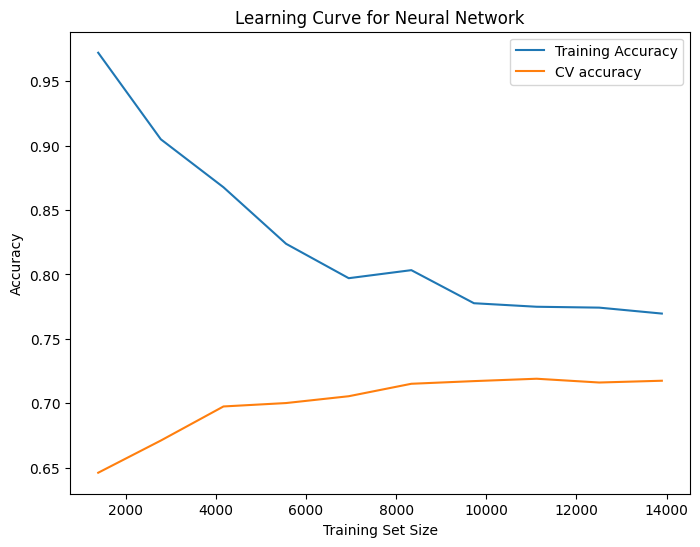

In [35]:
# vary the size of the training set
train_sizes = np.linspace(0.1, 1.0, 10)  # Adjust the number of points as needed

# generate learning curve data
train_sizes, train_accuracies, test_accuracies = learning_curve(
    neural_net, X_train_bigram, Y_train, cv=5, train_sizes=train_sizes, scoring="accuracy"
)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_accuracies.mean(axis=1), label="Training Accuracy")
plt.plot(train_sizes, test_accuracies.mean(axis=1), label="CV accuracy")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve for Neural Network")
plt.legend()
plt.show()


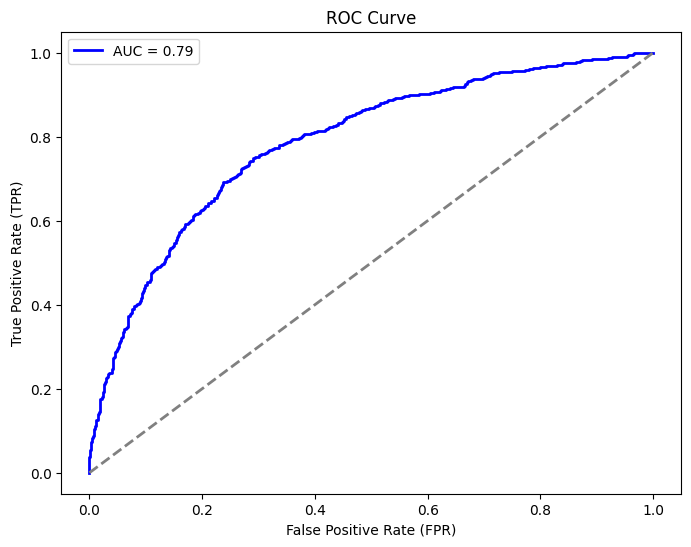

In [36]:

# make predictions on the test set
predictions_proba = neural_net.predict_proba(X_test_bigram)[:, 1]

# compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, predictions_proba)

# compute AUC
auc = roc_auc_score(Y_test, predictions_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [47]:
# lets look at what examples our classifier gets wrong
Y_predicted = neural_net.predict(X_test_bigram)
pd.set_option('display.max_colwidth', None)
predictions_df = pd.DataFrame({'Review': X_test, 'Actual Y': Y_test, 'Predicted Y': Y_predicted})



In [57]:
# filtering to show only rows where actual Y does not equal predicted Y
filt = predictions_df['Actual Y'] != predictions_df['Predicted Y']
predictions_df[filt].tail()



,Review,Actual Y,Predicted Y
21666,"there is much to claw through here, so much so that the audience might easily find themselves exhausted from the overall aggression of the film. however, a lot of the story does work. the action is good, and the emotion feels real most of the time.",1,0
3056,"pain hustlers struggles, in multiple ways, to be effective and leaves us with the feeling that the makers weren’t on the right side of the slant they ran with. it was too frivolously handled and it wasn’t clear what message it intended to get across.",0,1
18808,"with three storylines, a ludicrous performance by kidman, and baz's self-indulgence getting the best of him, australia is one of this year's biggest blunders.",0,1
13672,its sincerity is admirable.,1,0
6801,"this is a curious, slightly underwhelming offering. even so, falling flat as a result of being understated to a fault is a promising event in a genre dominated by obvious signposting, and wright is certainly one to watch for the future.",1,0


Thanks for taking the time to read through my ML project. I hope I was able to demonstrate a proficient knowledge of various ML techniques and models whilst also displaying my knowledge of various python packages such as scikit-learn. 